In [1]:
from __future__ import division

In [2]:
import numpy as np
from scipy.optimize import curve_fit
from math import sqrt

In [3]:
pi = np.pi
twopi = 2*pi

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc

In [814]:
import helpy
reload(helpy)

<module 'helpy' from 'helpy.pyc'>

In [6]:
import tracks, otracks
import orientation as orient
import correlation as corr
import curve

In [7]:
S = 17.5
fps = 120
freq = 50

In [8]:
rc('font', family='serif', serif=['Latin Modern', 'Computer Modern'])
rc('text', usetex=True)
smallfig = (5,4)
largefig = (8,6)

In [668]:
locdir = '/Users/leewalsh/Physics/Squares/Noise/Walker/'
savedir = '/Users/leewalsh/Physics/Squares/Noise/graphics/Walker/'

In [10]:
dataset_names = ['n8_100mv_50hz_{}'.format(i) for i in range(1,5)] + ['n2_pAB_1', 'n2_pAB_2', 'n2_pBC']

In [251]:
[len(tracksets[track]) for track in longtracks]

[7535, 7710, 7722, 7709, 7708, 7676, 7692, 7660]

using dtau = 10, dt0 = 10
using S = 20 pixels, thus A = 400 px^2


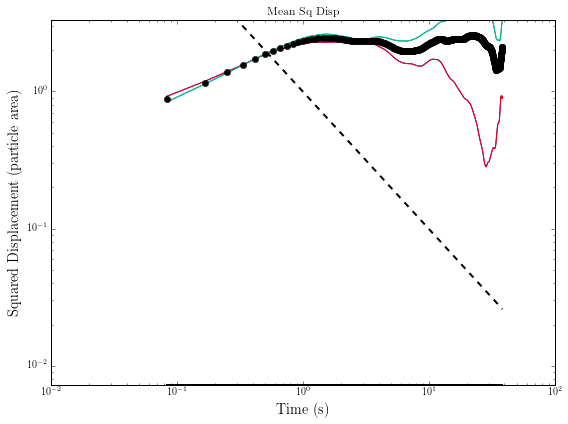

In [241]:
tracks.plot_msd(msds, msdids, dtau, dt0, nframes=len(fsets), tnormalize=1,
                fps=fps, S=S, #approx...
                figsize=largefig,
                #ylim=((msds[...,1]/msds[...,0]).min(),(msds[...,1]/msds[...,0]).max())
               )

using dtau = 10, dt0 = 10
using S = 20 pixels, thus A = 1 px^2


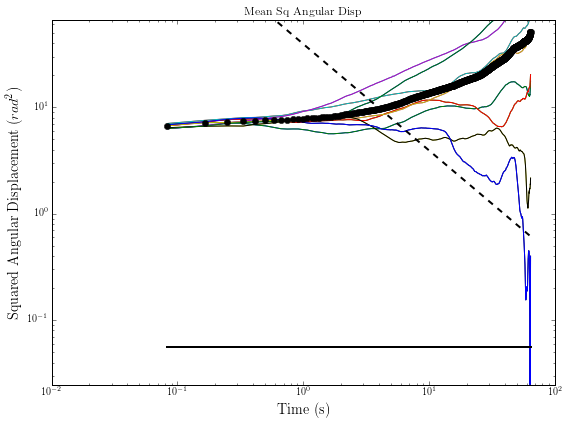

In [182]:
tracks.plot_msd(msads, msadids, dtau, dt0, nframes=len(fsets), ang=True, tnormalize=1,
                fps=fps, S=S, figsize=largefig)

In [186]:
rot_step = np.mean([np.abs(np.diff(odata[(data['lab']==track)&omask]['orient'])).mean()
                                          for track in longtracks])
print rot_step/pi, "* pi"

0.0729709440103 * pi


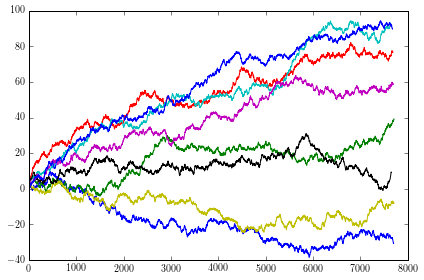

In [187]:
for track in longtracks:
    plt.plot(otracksets[track])

In [13]:
# Build up data dicts by track for all datasets
alltracksets = {}
allotracksets = {}
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    print prefix
    data, tracksets, odata, otracksets = helpy.loadall(prefix, ret_msd=False)
    alltracksets[prefix] = tracksets
    allotracksets[prefix] = otracksets

n8_100mv_50hz_1
loaded data for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_1
loading MSDs for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_1
n8_100mv_50hz_2
loaded data for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_2
loading MSDs for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_2
n8_100mv_50hz_3
loaded data for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_3
loading MSDs for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_3
n8_100mv_50hz_4
loaded data for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_4
loading MSDs for /Users/leewalsh/Physics/Squares/Noise/Walker/n8_100mv_50hz_4


# orientation autocorrelation $\langle \hat n(t) \hat n(t-dt) \rangle$

In [766]:
# Calculate all <nn> correlations
# That is, <cos(phi) cos(phi)> and <sin(phi) sin(phi)>

# These should both be False for the standard calculation:
norm = False     # forces autocrr[0] = 1
cumulant = False # subtracts mean of function first (mean of cos or sin should be zero anyway)

allocoscorr = {} # this is <n_i n_i>, the ii component of <nn>
allosincorr = {} #     and <n_j n_j>, the jj component of <nn>
allnncorr = {}  # This is the trace <n•n>
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    print prefix
    otracksets = allotracksets[prefix]
    allocoscorr[prefix] = {}
    allosincorr[prefix] = {}
    allnncorr[prefix] = {}
    for track, otrackset in otracksets.items():
        allocoscorr[prefix][track] = corr.autocorr(np.cos(otrackset), cumulant=cumulant, norm=norm)
        allosincorr[prefix][track] = corr.autocorr(np.sin(otrackset), cumulant=cumulant, norm=norm)
        allnncorr[prefix][track] = allocoscorr[prefix][track] + allosincorr[prefix][track]

n8_100mv_50hz_1
n8_100mv_50hz_2
n8_100mv_50hz_3
n8_100mv_50hz_4


In [816]:
locdir

'/Users/leewalsh/Physics/Squares/Noise/Walker/'

[ 12.89411641]
  D_R: 0.0776
1/D_R: 12.894


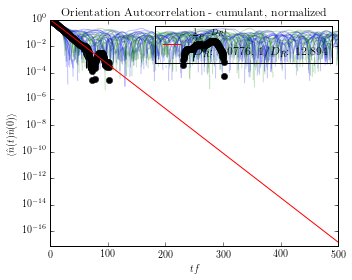

In [821]:
# Average, Fit and plot <nn> correlation
save = True
rc('text', usetex=save)
plt.figure(figsize=smallfig if save else largefig)

allcorr = []
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    normed = prefix.endswith('1') or prefix.endswith('2')
    color = 'b' if normed else 'r'
    for track in allotracksets[prefix]:
        coscorr = allocoscorr[prefix][track]
        sincorr = allosincorr[prefix][track]
        allcorr.append(coscorr)
        allcorr.append(sincorr)
        plt.semilogy(np.arange(len(coscorr))*freq/fps, coscorr, 'g', alpha=.25)
        plt.semilogy(np.arange(len(sincorr))*freq/fps, sincorr, 'b', alpha=.25)
allcorr = helpy.pad_uneven(allcorr, np.nan)
tcorr = np.arange(allcorr.shape[1])*freq/fps
meancorr = np.nanmean(allcorr, 0)
errcorr = np.nanstd(allcorr, 0)/sqrt(len(allcorr))
err_offset = errcorr.mean()
tmax = 500

plt.errorbar(tcorr, meancorr, errcorr, None, 'ok', capthick=0, elinewidth=1, errorevery=3)
plt.xlim(0, tmax)
fmax = np.searchsorted(tcorr, tmax)
fitform = lambda *args, **kwargs: curve.exp_decay(*args, **kwargs)
popt, pcov = curve_fit(fitform, tcorr[:fmax], meancorr[:fmax],
                       p0=[1/D_R], sigma=err_offset + errcorr[:fmax])
print popt
D_R = 1/popt[0]
print "  D_R: {:.4f}\n1/D_R: {:.3f}".format(D_R, 1/D_R)
plt.plot(tcorr, fitform(tcorr, *popt), 'r',
             label=r"$\frac{1}{2}e^{-D_R t}$" + '\n' + "$D_R$: {:.4f}, $1/D_R$: {:.3f}".format(D_R, 1/D_R))

plt.ylim(curve.exp_decay(tmax, *popt)/2, 1)

#plt.yscale('linear'); plt.ylim(-.2, .5)
plt.ylabel(r"$\langle \hat n(t) \hat n(0) \rangle$")
plt.xlabel("$tf$")
plt.title("Orientation Autocorrelation - cumulant, normalized")
plt.legend()
if save: plt.savefig(savedir+'nn-corr-normalized-cumulant.pdf')

# position-orientation correlation $\langle \vec r(t) \hat n(t - dt) \rangle$ 

In [824]:
# Calculate all <rn> correlations
# That is, <x cos(phi)> and <y sin(phi)>
alloxcorr = {}
alloycorr = {}
corr_args = {'side': 'both', 'ret_dx': True, 'cumulant': True}
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    print prefix
    tracksets = alltracksets[prefix]
    otracksets = allotracksets[prefix]
    alloxcorr[prefix] = {track: corr.crosscorr(tracksets[track]['x']/S,
                                               np.cos(otracksets[track]), **corr_args)
                         for track in tracksets.keys()}
    alloycorr[prefix] = {track: corr.crosscorr(tracksets[track]['y']/S,
                                               np.sin(otracksets[track]), **corr_args)
                         for track in tracksets.keys()}

n8_100mv_50hz_1
n8_100mv_50hz_2
n8_100mv_50hz_3
n8_100mv_50hz_4


bounds: -100 100
trange: -1457.91666667 1457.91666667 (6999,)
tlims:  -100 100
max corr (approx v0/D_R): 0.422392886664
flims:  3259 3739
fitlims:  -100.0 100.0

Fits:
v0/D_R: 0.2770
  dx_0: 0.1455
    v0: 0.0215
fit shape (6999,)
t shape (6999,)


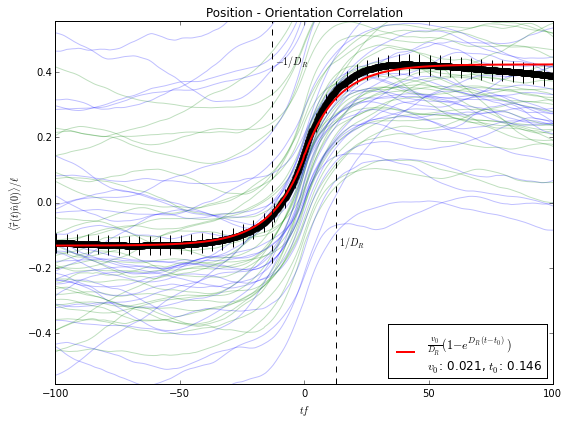

In [836]:
# Average, Fit and plot <rn> correlation
do_fit = True
save = False
rc('text', usetex=save)
plt.figure(figsize=smallfig if save else largefig)
allcorr = []
nframes = 3500
tcorr = np.arange(nframes)*freq/fps
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    for track in allotracksets[prefix]:
        if corr_args['ret_dx']:
            tcorr = alloxcorr[prefix][track][0]
            index = np.abs(tcorr) < nframes
            oxcorr = alloxcorr[prefix][track][1][index]
            oycorr = alloycorr[prefix][track][1][index]
            tcorr = tcorr[index]*freq/fps
        else:
            oxcorr = alloxcorr[prefix][track][:nframes]
            oycorr = alloycorr[prefix][track][:nframes]
        allcorr.append(oxcorr)
        allcorr.append(oycorr)
        plt.plot(tcorr, oxcorr, 'g', alpha=.25)
        plt.plot(tcorr, oycorr, 'b', alpha=.25)
allcorr = np.asarray(allcorr)
meancorr = np.nanmean(allcorr, 0)
errcorr = np.nanstd(allcorr, 0)/sqrt(len(allcorr))
err_offset = np.abs(errcorr.mean())
tmin = 0 if corr_args['side']=='right' else -100
tmax = 0 if corr_args['side']=='left'  else 100
plt.errorbar(tcorr, meancorr, errcorr, None,
             'ok', capthick=0, elinewidth=1, errorevery=10)
xlims = max(tmin, tcorr.min()), min(tmax, tcorr.max())
print "bounds:", tmin, tmax
print "trange:", tcorr.min(), tcorr.max(), tcorr.shape
print "tlims: ", xlims[0], xlims[1]
plt.xlim(*xlims)
#plt.ylim(1e-2, 2)

print 'max corr (approx v0/D_R):', meancorr.max()

if do_fit:
    fmin = np.searchsorted(tcorr, tmin)
    fmax = np.searchsorted(tcorr, tmax)
    print 'flims: ', fmin, fmax
    print 'fitlims: ', tcorr[fmin], tcorr[fmax]
    #fitform = lambda t, v_D, shift=0, D=D_R:\
    #          v_D*(1 - curve.exp_decay(t-shift, 1/D))
    #fitstr = r'$\frac{v_0}{D_R}(1 - e^{D_R(-t+t_0)})$'
    fitform = lambda t, v_D, shift=0, D=D_R:\
              shift + np.sign(t)*v_D*(1 - curve.exp_decay(np.abs(t), 1/D))
    fitstr = r'$c_0 + \sign(t)\frac{v_0}{D_R}(1 - e^{-D_R|t|})$'

    p0 = [1.0, 0]
    popt, pcov = curve_fit(fitform, tcorr[fmin:fmax], meancorr[fmin:fmax],
                           p0=p0, sigma=err_offset + errcorr[fmin:fmax]
                           )
    v0 = D_R*popt[0]
    dx0 = popt[1] if len(popt) > 1 else 0
    print "\nFits:"
    print '\n'.join(['v0/D_R: {:.4f}','  dx_0: {:.4f}',
                     '   D_R: {:.4f}'][:len(popt)]).format(*popt)
    print '    v0: {:.4f}'.format(v0)
    fit = fitform(tcorr, *popt)
    print 'fit shape', fit.shape
    print 't shape', tcorr.shape
    plt.plot(tcorr, fit, 'r', lw=2,
                 label=fitstr+'\n'+
                        '$v_0$: {:.3f}, $c_0$: {:.3f}'.format(v0, shift)
                )
plt.axvline(1/D_R, 0, 2/3, ls='--', c='k')
plt.text(1/D_R, fit.min(), ' $1/D_R$')
plt.axvline(-1/D_R, 1/3, 1, ls='--', c='k')
plt.text(-1/D_R, fit.max(), ' $-1/D_R$')

#plt.ylim(1e-3, 1)
plt.yscale('linear'); plt.ylim(-2*popt[0],2*popt[0])
plt.xlim(*xlims)
plt.title("Position - Orientation Correlation")
plt.ylabel(r"$\langle \vec r(t) \hat n(0) \rangle / \ell$")
plt.xlabel("$tf$")
plt.legend(loc=0, framealpha=1)
if save: plt.savefig(savedir+'rn-corr-linear.pdf')

# position-position correlation (MSD) $\langle \vec r(t) \vec r(t') \rangle$

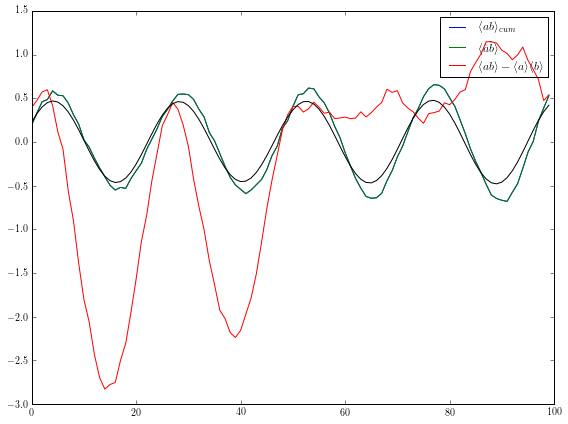

In [192]:
L = 100
x = np.linspace(0, 2*pi, L)
a = np.sin(x*4) + 2*np.random.rand(L) + 9
b = np.sin(x*4.2) + np.random.rand(L) - 7
side = 'both'
acs = {r"$\langle a(t) b(t+s)\rangle_{cum}$":
            corr.crosscorr(a, b, cumulant=True, side=side),
        r"$\langle ab\rangle - \langle a\rangle\langle b\rangle$":
            corr.crosscorr(a, b, side=side) - a.mean()*b.mean(),
        r"$\langle a(t)b(t+s)\rangle - \langle a b\rangle$":
            corr.crosscorr(a, b, side=side) - np.dot(a,b),
        r"$\langle \hat a \hat b \rangle$":
            corr.crosscorr(a-a.mean(), b-b.mean(), side=side)
        }
AC = corr.crosscorr(np.sin(x*4), np.sin(x*4.2), side=side)
#keys, vals = zip(*acs.items())
#acstack = np.row_stack(vals)
#print ", ".join(keys)
#print acstack[:,:3]

plt.figure(figsize=largefig)
for name, ac in acs.iteritems():
    plt.plot(ac, label=name)
plt.plot(AC, 'k')
plt.legend()

In [467]:
def loop_msd(xs, dt0, dtau):
    """Slowly but surely calculate the MSD"""
    d = xs.ndim
    if d==2:
        T, d = xs.shape
    else:
        T = len(xs)
    msd = []
    taus = xrange(0, T, dtau)
    for tau in taus:
        csd = 0
        nt0 = 0
        t0s = xrange(0, T - tau, dt0)
        for t0 in t0s:
            nt0 += 1
            if d==1:
                xi, xf = xs[t0], xs[t0+tau]
                sd = (xf - xi)**2
            elif d==2:
                (xi, yi), (xf, yf) = xs[t0], xs[t0+tau]
                sd = (xf - xi)**2 + (yf - yi)**2
            else:
                print 'what dimension is this?'
            csd += sd
        msd.append(csd/nt0)
    return np.asarray(msd)

-4.46464954239 -0.937364681797
True


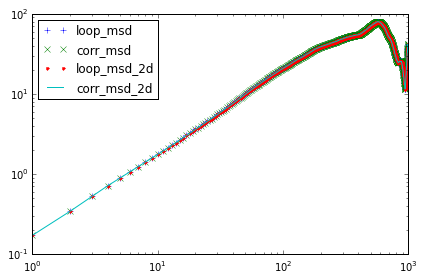

In [475]:
# Test equivalence of various methods to get MSD
N = 1000
x = np.cumsum(np.random.rand(N) - .5)
y = np.cumsum(np.random.rand(N) - .5)
xy = np.column_stack([x,y])
print x.mean(), y.mean()

ml = loop_msd(x, 1, 1) + loop_msd(y, 1, 1)
mc = corr.msd(x, False) + corr.msd(y, False)
ml2 = loop_msd(xy, 1, 1)
mc2 = corr.msd(xy, False)
print np.allclose(ml, [mc, ml2, mc2])
plt.figure()
plt.clf()
#plt.loglog(dx, dx/dx[1]*ml[1], label='slope 1')
plt.loglog(np.arange(1, N), ml[1:],  '+', label='loop_msd')
plt.loglog(np.arange(1, N), mc[1:],  'x', label='corr_msd')
plt.loglog(np.arange(1, N), ml2[1:], '.', label='loop_msd_2d')
plt.loglog(np.arange(1, N), mc2[1:], label='corr_msd_2d')
plt.legend(loc=0)
#plt.ylim(1e-3,1e2)

In [811]:
reload(corr)
reload(helpy)

<module 'helpy' from 'helpy.py'>

In [482]:
# Calculate all <rr> correlations
# That is, MSD.
allmsds = {}
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    print prefix
    allmsds[prefix] = {track: corr.msd(np.column_stack([tracksets[track]['x'], tracksets[track]['y']])/S)
                        for track in alltracksets[prefix]}

n8_100mv_50hz_1
n8_100mv_50hz_2
n8_100mv_50hz_3
n8_100mv_50hz_4


earlier fits D_R: 0.077, v_0: 0.018, v0**2/D_R: 0.004
popt: D_T: 0.006, v_0: 0.0532
sopt: v_0: 0.084
dopt: D_eff: 0.032


helpy.py:129: RuntimeWarning: invalid value encountered in divide
  dy = np.diff(np.log(y)) / np.diff(np.log(x))


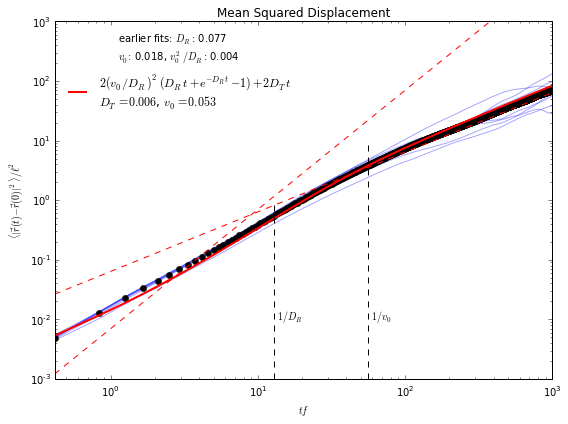

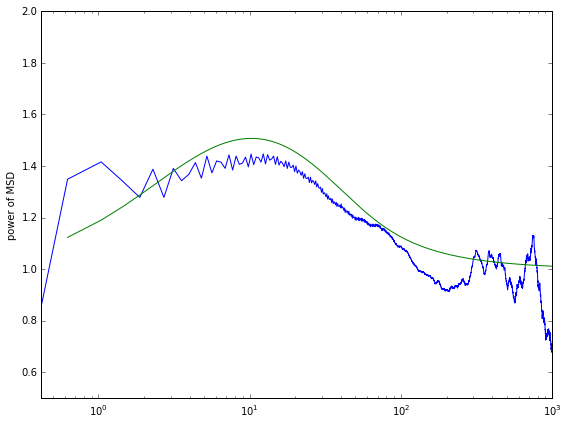

In [813]:
# Average, Fit and plot <rr> correlation (MSD)
do_fit = True
save = False

rc('text', usetex=save)
plt.figure(figsize=smallfig if save else largefig)
msds = []
for prefix in dataset_names:
    if 'n8' not in prefix: continue
    for track in alltracksets[prefix]:
        trackmsd = allmsds[prefix][track]
        taus = np.arange(len(trackmsd))*freq/fps
        msds.append(trackmsd)
        plt.loglog(taus, trackmsd, 'b', alpha=.1)
msds = helpy.pad_uneven(msds, np.nan)
MSD = np.nanmean(msds, 0)
N = np.sum(np.isfinite(msds), 0)
msderr = np.nanstd(msds, 0)/sqrt(len(msds))
err_offset = np.abs(msderr.mean())

taus = np.arange(len(MSD))*freq/fps
tmin, tmax = taus[1], 1000
plt.errorbar(taus, MSD, msderr, None, 'ok', capthick=0, elinewidth=1, errorevery=10)
#plt.plot(taus, MSD[1000]*(taus/taus[1000])**1, 'r')
#plt.plot(taus, MSD[10]*(taus/taus[10])**1.5, 'r')
xlims = max(tmin, taus.min()), min(tmax, taus.max())

if do_fit:
    fmax = np.searchsorted(taus, tmax)
    fdr =  np.searchsorted(taus, 1/D_R)
    fmin = np.searchsorted(taus, tmin)
    def fitform(t, D, v=v0, DR=D_R, method='bala'):
        f = {'bala'  : 2*(v/DR)**2 * (- 1 + DR*t + np.exp(-DR*t)) + 2*D*t, # From Balakrishnan, fits best
             'exer'  : 2*(v/DR)**2 * (+ 1 - DR*t - np.exp(-DR*t)) + 2*D*t, # From my work in exercise
             'aparna': 2*(v/DR)**2 * (+ 1 + DR*t - np.exp(-DR*t)) + 2*D*t, # From Aparna's solutions
             'kaush' : None, # my integral is bad
            }
        return f[method]
    fitshort= lambda t, v=v0: v*v*t*t
    fitlong = lambda t, D, v=v0, DR=D_R: 2*(v*v/DR + D)*t
    fitdiff = lambda t, D: 2*D*t
    p0 = [0, v0]
    ps = [v0]
    pl = [0]
    pd = [v0*v0/D_R]
    popt, pcov = curve_fit(fitform, taus[fmin:fmax], MSD[fmin:fmax],
                           p0=p0, sigma=msderr[fmin:fmax]*np.log(1+taus[fmin:fmax]/taus[fmin]))
    sopt, pcov = curve_fit(fitshort, taus[fmin:fdr], MSD[fmin:fdr],
                           p0=ps, sigma=msderr[fmin:fdr]*np.log(1+taus[fmin:fdr]/taus[fmin]))
    #lopt, pcov = curve_fit(fitlong, taus[fdr:fmax], MSD[fdr:fmax],
    #                       p0=pl, sigma=msderr[fdr:fmax]*np.log(1+taus[fdr:fmax]/taus[fmin]))
    dopt, pcov = curve_fit(fitdiff, taus[fdr:fmax], MSD[fdr:fmax],
                          p0=pd, sigma=msderr[fdr:fmax]*np.log(1+taus[fdr:fmax]/taus[fmin]))
    print 'earlier fits D_R: {:.3f}, v_0: {:.3f}, v0**2/D_R: {:.3f}'.format(D_R, v0, v0*v0/D_R)
    print 'popt:', ', '.join(["D_T: {:.3f}", "v_0: {:.3g}", "D_R: {:.3f}"][:len(popt)]).format(*popt)
    print 'sopt:', ', '.join(["v_0: {:.3f}"][:len(sopt)]).format(*sopt)
    #print 'lopt:', ', '.join(["D_T: {:.3f}", "v_0: {:.3f}", "D_R: {:.3f}"][:len(lopt)]).format(*lopt)
    print 'dopt:', ', '.join(["D_eff: {:.3f}"][:len(dopt)]).format(*dopt)
    #for fit, label, fmt in zip(
    #       [fitform(taus, *popt), fitshort(taus, *sopt), fitlong(taus, *lopt), fitdiff(taus, *dopt)],
    #       [', '.join(['full',"$D_T= {:.3f}$", "$v_0= {:.3g}$", "$D_R= {:.3f}$"][:1+len(popt)]).format(*popt),
    #        ', '.join(['shrt', "$v_0= {:.3f}$"][:1+len(sopt)]).format(*sopt),
    #        ', '.join(['long', "$D_T= {:.3f}$", "$v_0= {:.3f}$", "$D_R= {:.3f}$"][:1+len(lopt)]).format(*lopt),
    #        ', '.join(['diff', "$D_{{eff}}= {:.3f}$"]).format(*dopt),
    #       ],
    #        ['-r', '-g', '+b', 'xc']
    #        ):
    #    plt.loglog(taus, fit, fmt, label=label)
    fit = fitform(taus, *popt)
    plt.loglog(taus, fit, '-r', lw=2,
              label="$2(v_0/D_R)^2 (D_Rt + e^{{-D_Rt}} - 1) + 2D_Tt$\n" + \
                    ', '.join(["$D_T= {:.3f}$", "$v_0 = {:.3f}$"][:len(popt)]).format(*popt),
              )
    plt.loglog(taus, fitshort(taus, *sopt), '--r')
    plt.loglog(taus, fitdiff(taus, *dopt), '--r')
#plt.yscale('linear')
#plt.ylim(fit_func(tmax, *popt)/2, 1)
plt.legend(loc="upper left", frameon=False,
           title='earlier fits: $D_R$: {:.3f}\n$v_0$: {:.3f}, $v_0^2/D_R$: {:.3f}'.format(D_R, v0, v0*v0/D_R))
plt.xlim(*xlims)
plt.ylim(1e-3, 1e3)
plt.axvline(1/D_R, 0, 1/2, ls='--', c='k')
plt.text(1/D_R, 1e-2, ' $1/D_R$')
plt.axvline(1/v0, 0, 2/3, ls='--', c='k')
plt.text(1/v0, 1e-2, ' $1/v_0$')
plt.title("Mean Squared Displacement")
plt.xlabel("$tf$")
plt.ylabel(r"$\langle |\vec r(t) - \vec r(0)|^2 \rangle/\ell^2$")
if save: plt.savefig(savedir+'msd.pdf')
    
plt.figure(figsize=smallfig if save else largefig)
plt.semilogx(*helpy.loglog_slope(taus, MSD, smooth=0))
plt.semilogx(*helpy.loglog_slope(taus, fit, smooth=0))
plt.xlim(*xlims)
plt.ylim(0.5, 2)
plt.ylabel("power of MSD")